In [1]:
# === SEKCJA 1: IMPORT I KONFIGURACJA ===
import pandas as pd
import numpy as np
import re
import warnings

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Concatenate, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from IPython.display import display
import matplotlib.pyplot as plt

# ZMIANA: Ignorowanie ostrzeżeń, które teraz obsługujemy przy wczytywaniu
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)

print("Wczytywanie danych...")
# ZMIANA: Dodano `low_memory=False` aby uniknąć DtypeWarning i zapewnić spójność typów
df_main = pd.read_csv('data.csv', sep=',', low_memory=False)
df_ulic = pd.read_csv('Ulic.csv', sep=',')
print("Wszystkie pliki wczytane.")

Wczytywanie danych...
Wszystkie pliki wczytane.


In [2]:
# === SEKCJA 2: PRZYGOTOWANIE DANYCH ===
df_ulic.rename(columns={'Name': 'NAZWA_ULICY'}, inplace=True)
df_ulic.dropna(subset=['SymUl', 'NAZWA_ULICY'], inplace=True)
street_dictionary = pd.Series(df_ulic.NAZWA_ULICY.values, index=df_ulic.SymUl).to_dict()

df_processed = df_main.copy()
df_processed.dropna(subset=['Area', 'Price', 'Description', 'Location', 'StreetNumber'], inplace=True)

def process_location(row):
    location_str, district, street = row['Location'], np.nan, np.nan
    if isinstance(location_str, str):
        parts = [p.strip() for p in location_str.split(',')]
        if len(parts) >= 3 and 'warszawa' in parts[1].lower(): district = parts[2]
    if pd.notna(row['StreetNumber']):
        try:
            street_sym = int(row['StreetNumber'])
            if street_sym in street_dictionary: street = street_dictionary[street_sym]
        except (ValueError, TypeError): pass
    if pd.isna(street) and isinstance(location_str, str) and len(location_str.split(',')) >= 4:
        street = location_str.split(',')[3].strip()
    if isinstance(street, str):
        street = re.sub(r'^(ul\\.|al\\.|pl\\.)\\s*', '', street, flags=re.IGNORECASE).lower()
        if len(street) < 3: street = np.nan
    return pd.Series([district, street])

df_processed[['District', 'Ulica_clean']] = df_processed.apply(process_location, axis=1)
df_processed.dropna(subset=['Ulica_clean', 'District'], inplace=True)

MIN_SAMPLES_PER_STREET = 25
street_counts = df_processed['Ulica_clean'].value_counts()
streets_to_remove = street_counts[street_counts < MIN_SAMPLES_PER_STREET].index
df_model_ready = df_processed[~df_processed['Ulica_clean'].isin(streets_to_remove)].copy()
print(f"Finalny zbiór danych gotowy. Wiersze: {len(df_model_ready)}, Ulice: {df_model_ready['Ulica_clean'].nunique()}")

Finalny zbiór danych gotowy. Wiersze: 52543, Ulice: 682


In [3]:
# === SEKCJA 3: INŻYNIERIA CECH (Z LEMATYZACJĄ) ===

# Instalacja morfeusz2, jeśli nie jest zainstalowany
!pip install morfeusz2
import morfeusz2

# Inicjalizacja lematyzatora
morf = morfeusz2.Morfeusz()

def clean_and_lemmatize_text(text):
    # 1. Czyszczenie tekstu (tak jak poprzednio)
    text = re.sub(r'[^a-ząęółśżźćń ]', '', str(text).lower())
    
    # 2. Lematyzacja
    analysis = morf.analyse(text)
    lemmas = []
    for _, _, interp in analysis:
        # Bierzemy formę podstawową słowa (lemat)
        lemmas.append(interp[0].split(':')[0])
        
    return ' '.join(lemmas)

# ZASTOSOWANIE NOWEJ FUNKCJI
df_model_ready['description_clean'] = df_model_ready['Description'].apply(clean_and_lemmatize_text)

# Funkcja do ekstrakcji kontekstu zabudowy (bez zmian)
def get_building_context(description):
    desc = str(description).lower()
    if any(word in desc for word in ['kamienica', 'przedwojenna', 'cegły', 'historyczna']):
        return 'kamienica'
    if any(word in desc for word in ['blok', 'wielka płyta', 'wieżowiec', 'płyt', 'blokowisko']):
        return 'blok'
    if any(word in desc for word in ['apartamentowiec', 'nowe budownictwo', 'nowy budynek', 'inwestycja', 'developerski']):
        return 'apartamentowiec'
    if any(word in desc for word in ['dom', 'szeregowiec', 'bliźniak', 'segment']):
        return 'dom'
    return 'inny'

df_model_ready['BuildingContext'] = df_model_ready['Description'].apply(get_building_context)

MAX_WORDS, MAX_LEN = 20000, 200
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(df_model_ready['description_clean'])
sequences = tokenizer.texts_to_sequences(df_model_ready['description_clean'])
X_text = pad_sequences(sequences, maxlen=MAX_LEN)

numeric_features = ['Area', 'Price', 'NumberOfRooms', 'Floor', 'Floors']
numeric_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
X_numeric = numeric_pipeline.fit_transform(df_model_ready[numeric_features])

categorical_features = ['District', 'BuildingType', 'BuildingContext']
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
X_categorical = cat_pipeline.fit_transform(df_model_ready[categorical_features])

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_model_ready['Ulica_clean'])
num_classes = len(label_encoder.classes_)
print("Dane przygotowane do treningu (z lematyzacją).")

Dane przygotowane do treningu (z lematyzacją).


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)       │ (None, 200)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 200, 128)          │       2,560,000 │ text_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional (Bidirectional) │ (None, 256)               │         263,168 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ numeric_input (InputLayer)    │ (None, 5)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ categorical_input             │ (None, 42)                │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 303)               │               0 │ bidirectional[0][0],       │
│                               │                           │                 │ numeric_input[0][0],       │
│                               │                           │                 │ categorical_input[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 512)               │         155,648 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 512)               │           2,048 │ dense[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 512)               │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 256)               │         131,328 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 256)               │           1,024 │ dense_1[0][0]              │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 256)               │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 682)               │         175,274 │ dropout_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 3,288,490 (12.54 MB)

 Trainable params: 3,286,954 (12.54 MB)

 Non-trainable params: 1,536 (6.00 KB)


Rozpoczynam trening sieci neuronowej (wersja z Bidirectional LSTM)...
Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 164s 968ms/step - accuracy: 0.0743 - loss: 5.6975 - val_accuracy: 0.1189 - val_loss: 5.5213 - learning_rate: 0.0010
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 149s 903ms/step - accuracy: 0.1793 - loss: 3.5355 - val_accuracy: 0.2037 - val_loss: 4.3044 - learning_rate: 0.0010
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 150s 911ms/step - accuracy: 0.2297 - loss: 3.1680 - val_accuracy: 0.2652 - val_loss: 3.2046 - learning_rate: 0.0010
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 149s 904ms/step - accuracy: 0.2794 - loss: 2.8946 - val_accuracy: 0.2963 - val_loss: 2.8637 - learning_rate: 0.0010
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 145s 879ms/step - accuracy: 0.3355 - loss: 2.6423 - val_accuracy: 0.3236 - val_loss: 2.7226 - learning_rate: 0.0010
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 150s 909ms/step - accuracy: 0.3924 - loss: 2.3890 - val_accuracy: 0.3514 - val_loss: 2.6208 - learning_rate: 

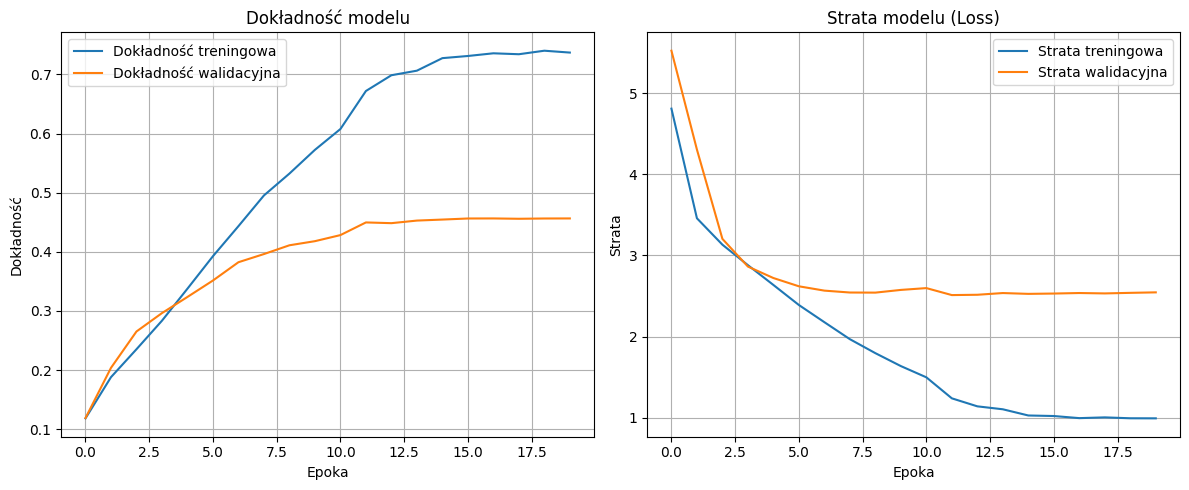

In [4]:
# === SEKCJA 4: BUDOWA I TRENING - WERSJA Z BIDIRECTIONAL LSTM I INŻYNIERIĄ CECH ===

# Definicja architektury z Bidirectional LSTM
input_text = Input(shape=(MAX_LEN,), name='text_input')
input_numeric = Input(shape=(X_numeric.shape[1],), name='numeric_input')
input_categorical = Input(shape=(X_categorical.shape[1],), name='categorical_input')

embedding_layer = Embedding(input_dim=MAX_WORDS, output_dim=128)(input_text)
# ZMIANA: Zastosowanie Bidirectional LSTM
lstm_layer = Bidirectional(LSTM(128, dropout=0.2))(embedding_layer)
concatenated = Concatenate()([lstm_layer, input_numeric, input_categorical])

# Warstwy gęste jak w oryginalnej, dobrze działającej wersji
x = Dense(512, activation='relu')(concatenated)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=[input_text, input_numeric, input_categorical], outputs=output_layer)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Podział i trening
X_train_text, X_val_text, X_train_num, X_val_num, X_train_cat, X_val_cat, y_train, y_val = train_test_split(
    X_text, X_numeric, X_categorical, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

print("\nRozpoczynam trening sieci neuronowej (wersja z Bidirectional LSTM)...")
history = model.fit(
    [X_train_text, X_train_num, X_train_cat], y_train,
    validation_data=([X_val_text, X_val_num, X_val_cat], y_val),
    epochs=20,
    batch_size=256,
    callbacks=[early_stopping, reduce_lr]
)

# Zapis modelu
model.save('street_predictor_final_v4.keras')
print("\nModel został wytrenowany i zapisany jako 'street_predictor_final_v4.keras'.")

# Wizualizacja
print("\nGenerowanie wykresów uczenia...")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Dokładność treningowa')
plt.plot(history.history['val_accuracy'], label='Dokładność walidacyjna')
plt.title('Dokładność modelu')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Strata treningowa')
plt.plot(history.history['val_loss'], label='Strata walidacyjna')
plt.title('Strata modelu (Loss)')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [5]:
# === SEKCJA 5: PREDYKCJA NA CAŁEJ BAZIE I WZBOGACENIE DANYCH (Z LEMATYZACJĄ) ===

print("Przygotowywanie całego zbioru danych do predykcji...")

# Stworzenie kopii oryginalnego zbioru danych
df_predict_base = df_main.copy()

# 1. Stosowanie tych samych transformacji, co na zbiorze treningowym
df_predict_base[['District', 'Ulica_clean']] = df_predict_base.apply(process_location, axis=1)

# ZMIANA: Zastosowanie tej samej funkcji do czyszczenia i lematyzacji
df_predict_base['description_clean'] = df_predict_base['Description'].apply(clean_and_lemmatize_text)

# Zastosowanie tej samej funkcji do ekstrakcji kontekstu zabudowy
df_predict_base['BuildingContext'] = df_predict_base['Description'].apply(get_building_context)


# Wypełnienie braków w danych, które mogą powodować błędy w pipeline'ach
df_predict_base['description_clean'].fillna('brak opisu', inplace=True)
for col in numeric_features:
    df_predict_base[col].fillna(0, inplace=True)
for col in categorical_features:
    df_predict_base[col].fillna('missing', inplace=True)

# 2. Transformacja danych przy użyciu WYTRENOWANYCH pipeline'ów i tokenizera
sequences_pred = tokenizer.texts_to_sequences(df_predict_base['description_clean'])
X_text_full = pad_sequences(sequences_pred, maxlen=MAX_LEN)
X_numeric_full = numeric_pipeline.transform(df_predict_base[numeric_features])
X_categorical_full = cat_pipeline.transform(df_predict_base[categorical_features])

print("Generowanie predykcji dla całego zbioru danych...")
# 3. Predykcja
predictions_proba = model.predict([X_text_full, X_numeric_full, X_categorical_full])
predicted_labels_encoded = np.argmax(predictions_proba, axis=1)
predicted_street_names = label_encoder.inverse_transform(predicted_labels_encoded)
predicted_probabilities = np.max(predictions_proba, axis=1)

# 4. Dodanie wyników do DataFrame
df_predict_base['Predicted_Ulica'] = predicted_street_names
df_predict_base['Predicted_Ulica_Prob'] = predicted_probabilities

print("Predykcja zakończona. Dane zostały wzbogacone.")

Przygotowywanie całego zbioru danych do predykcji...
Generowanie predykcji dla całego zbioru danych...
6133/6133 ━━━━━━━━━━━━━━━━━━━━ 322s 52ms/step
Predykcja zakończona. Dane zostały wzbogacone.


In [7]:
# === SEKCJA 6: WERYFIKACJA I KOREKTA PREDYKCJI (WERSJA POPRAWIONA) ===

print("Tworzenie mapy ulica -> dzielnica na podstawie danych treningowych...")
# Używamy df_model_ready, bo zawiera tylko te ulice i dzielnice, na których model był uczony
street_to_district_map = df_model_ready.drop_duplicates(subset='Ulica_clean').set_index('Ulica_clean')['District'].to_dict()

# --- Korekta predykcji ---
print("Weryfikacja i korekta predykcji w oparciu o dzielnicę...")

# Pobierz top 3 predykcje i ich prawdopodobieństwa
top_k = 3
top_k_indices = np.argsort(predictions_proba, axis=1)[:, -top_k:]
top_k_probs = np.sort(predictions_proba, axis=1)[:, -top_k:]

corrected_streets = []
corrected_probs = []
correction_counter = 0

for i in range(len(df_predict_base)):
    original_district = df_predict_base.loc[i, 'District']
    is_corrected = False
    
    # Sprawdzamy predykcje od najlepszej do najgorszej (w ramach top_k)
    for j in range(top_k - 1, -1, -1):
        pred_street_idx = top_k_indices[i, j]
        pred_street_name = label_encoder.classes_[pred_street_idx]
        pred_street_district = street_to_district_map.get(pred_street_name)

        # Jeśli dzielnica jest znana i zgadza się z oryginalną, akceptujemy tę predykcję
        if pd.notna(original_district) and original_district != 'missing' and original_district == pred_street_district:
            corrected_streets.append(pred_street_name)
            corrected_probs.append(top_k_probs[i, j])
            if j < top_k - 1: # Jeśli nie była to pierwsza (najlepsza) predykcja
                correction_counter += 1
            is_corrected = True
            break
    
    # Jeśli żadna z top_k predykcji nie pasowała, bierzemy pierwotną (najlepszą)
    if not is_corrected:
        corrected_streets.append(df_predict_base.loc[i, 'Predicted_Ulica'])
        corrected_probs.append(df_predict_base.loc[i, 'Predicted_Ulica_Prob'])

# Zastąpienie starych predykcji nowymi, skorygowanymi
df_predict_base['Corrected_Ulica'] = corrected_streets
df_predict_base['Corrected_Ulica_Prob'] = corrected_probs

print(f"Liczba predykcji skorygowanych na podstawie dzielnicy: {correction_counter}")

# --- Ponowna weryfikacja po korekcie ---
df_predict_base['Corrected_Ulica_District'] = df_predict_base['Corrected_Ulica'].map(street_to_district_map)

# ZMIANA: Dodanie brakującej definicji funkcji verify_prediction
def verify_prediction(row):
    # Sprawdzamy tylko dla wierszy, gdzie mamy oryginalną dzielnicę (nie 'missing' lub NaN)
    if pd.notna(row['District']) and row['District'] != 'missing':
        # Porównujemy oryginalną dzielnicę z dzielnicą przypisaną do SKORYGOWANEJ ulicy
        if row['District'] == row['Corrected_Ulica_District']:
            return 'Zgodna'
        else:
            return 'Niezgodna'
    return 'Brak danych do weryfikacji'

df_predict_base['Prediction_Status'] = df_predict_base.apply(verify_prediction, axis=1)

# Wyświetlanie statystyk spójności
print("\nStatystyki spójności po korekcie:")
print(df_predict_base['Prediction_Status'].value_counts())

# Wyświetlanie przykładów niezgodnych predykcji (jak ta, którą znalazłeś)
print("\nPrzykładowe 10 losowych niezgodnych predykcji:")
display_cols_check = ['SaleId', 'Location', 'District', 'Corrected_Ulica', 'Corrected_Ulica_District', 'Corrected_Ulica_Prob', 'Description']
display(df_predict_base[df_predict_base['Prediction_Status'] == 'Niezgodna'][display_cols_check].sample(10, random_state=1))

# Wyświetlanie przykładowych wyników końcowych
print("\nPrzykładowe 25 losowych wierszy z uzupełnionymi i skorygowanymi danymi:")
display_cols = ['SaleId', 'Location', 'District', 'Corrected_Ulica', 'Corrected_Ulica_District', 'Prediction_Status', 'Corrected_Ulica_Prob', 'Price', 'Area']
display(df_predict_base[display_cols].sample(25, random_state=42))

# Zapis do pliku CSV
output_filename_corrected = 'data_with_corrected_streets.csv'
df_predict_base.to_csv(output_filename_corrected, index=False, sep=',')
print(f"\nFinalny DataFrame ({len(df_predict_base)} wierszy) zapisano do pliku: {output_filename_corrected}")

Tworzenie mapy ulica -> dzielnica na podstawie danych treningowych...
Weryfikacja i korekta predykcji w oparciu o dzielnicę...
Liczba predykcji skorygowanych na podstawie dzielnicy: 8539

Statystyki spójności po korekcie:
Prediction_Status
Zgodna                        129063
Brak danych do weryfikacji     66341
Niezgodna                        836
Name: count, dtype: int64

Przykładowe 10 losowych niezgodnych predykcji:


,SaleId,Location,District,Corrected_Ulica,Corrected_Ulica_District,Corrected_Ulica_Prob,Description
194328,4403407,"Mazowieckie, Warszawa, Wola, Mirów, Ul. Grzybo...",Wola,grzybowska,Śródmieście,0.385357,Biuro Nieruchomości Esteum prezentuje: mieszka...
69526,2706127,"Mazowieckie, Warszawa, Ursynów",Ursynów,dolna,Mokotów,0.324577,"Mieszkanie, Warszawa, Ursynów, 51 m² Ogłoszeni..."
59619,2300398,"Mazowieckie, Warszawa, Wola, Czyste",Wola,pawia,Śródmieście,0.434704,"Mieszkanie Inwestycyjne Mega okazja ROI 7,7% ?..."
190763,4371039,"Mazowieckie, Warszawa, Wesoła, Ul. Wschodnia",Wesoła,obozowa,Wola,0.172893,Biura nieruchomości zapraszamy tylko z kliente...
49783,2039392,"Mazowieckie, Warszawa, Ochota, Ul. Maurycego M...",Ochota,juliana ursyna niemcewicza,Wesoła,0.531057,"We speak English, so feel free and call ! :) N..."
97662,3038229,"Mazowieckie, Warszawa, Śródmieście",Śródmieście,chmielna,Wola,0.254008,"Mieszkanie, Warszawa, Śródmieście, 23 m² Ogłos..."
112876,3241969,"Mazowieckie, Warszawa, Wesoła",Wesoła,geodezyjna,Białołęka,0.115358,"Mieszkanie, Warszawa, Wesoła, 43 m² Ogłoszenio..."
113332,3248239,"Mazowieckie, Warszawa, Wesoła",Wesoła,geodezyjna,Białołęka,0.230665,"Mieszkanie, Warszawa, Wesoła, 42 m² Ogłoszenio..."
2344,90625,"Mazowieckie, Warszawa, Wesoła",Wesoła,stefana żeromskiego,Bielany,0.092925,Sprzedam bardzo jasne mieszkanie w 2 piętrowym...
108716,3182548,"Mazowieckie, Warszawa, Ochota",Ochota,grójecka,Targówek,0.331088,"Mieszkanie, Warszawa, Ochota, 41 m² Ogłoszenio..."



Przykładowe 25 losowych wierszy z uzupełnionymi i skorygowanymi danymi:


,SaleId,Location,District,Corrected_Ulica,Corrected_Ulica_District,Prediction_Status,Corrected_Ulica_Prob,Price,Area
117971,3306651,"Mazowieckie, Warszawa, Mokotów, Ul. Polska",Mokotów,polska,Mokotów,Zgodna,0.999244,992250.0,55.90
105430,3136257,"Mazowieckie, Warszawa, Białołęka, Ul. Winorośli",Białołęka,marywilska,Białołęka,Zgodna,0.204888,0.0,50.00
130903,3506482,"Mazowieckie, Warszawa, Mokotów, Ksawerów",Mokotów,domaniewska,Mokotów,Zgodna,0.310530,1904000.0,83.95
180140,4249856,"Mazowieckie, Grodziski, Grodzisk Mazowiecki",missing,geodezyjna,Białołęka,Brak danych do weryfikacji,0.451566,699000.0,55.00
73766,2760208,"Mazowieckie, Warszawa, Bemowo, Ul. Strońska",Bemowo,gen. waleriana czumy,Bemowo,Zgodna,0.415556,850000.0,66.70
85493,2889192,"Mazowieckie, Radomski, Zakrzew, Bielicha",missing,augustówka,Mokotów,Brak danych do weryfikacji,0.075390,299000.0,67.50
19147,913358,"Mazowieckie, Warszawa, Ursus, Ul. Przy Forcie",Ursus,karola taylora,Ursus,Zgodna,0.366038,0.0,49.74
139381,3652415,"Mazowieckie, Warszawa, Praga-południe, Ul. Pol...",Praga-południe,igańska,Praga-południe,Zgodna,0.470077,865000.0,51.10
20811,954853,"Mazowieckie, Warszawa, Ursus, Ul. Szamoty",Ursus,herbu oksza,Ursus,Zgodna,0.953283,0.0,54.76
143413,3713496,"Mazowieckie, Legionowski, Legionowo, Ul. Husarska",missing,brązownicza,Bielany,Brak danych do weryfikacji,0.090118,525000.0,54.00



Finalny DataFrame (196240 wierszy) zapisano do pliku: data_with_corrected_streets.csv


In [8]:
# === SEKCJA 7: OBLICZENIE DOKŁADNOŚCI NA POZIOMIE DZIELNIC ===

print("Obliczanie dokładności predykcji na poziomie dzielnic (na zbiorze walidacyjnym)...")

# 1. Wykonaj predykcję na zbiorze walidacyjnym
y_pred_proba_val = model.predict([X_val_text, X_val_num, X_val_cat])
y_pred_encoded_val = np.argmax(y_pred_proba_val, axis=1)

# 2. Odkoduj przewidziane i prawdziwe NAZWY ULIC
predicted_streets_val = label_encoder.inverse_transform(y_pred_encoded_val)
true_streets_val = label_encoder.inverse_transform(y_val)

# 3. Zmapuj ulice na ich DZIELNICE
# Używamy tej samej mapy co w kroku weryfikacji
predicted_districts_val = [street_to_district_map.get(s, 'nieznana') for s in predicted_streets_val]
true_districts_val = [street_to_district_map.get(s, 'nieznana') for s in true_streets_val]

# 4. Oblicz dokładność
from sklearn.metrics import accuracy_score
district_accuracy = accuracy_score(true_districts_val, predicted_districts_val)

print(f"\nDokładność predykcji na poziomie ulic (val_accuracy): {history.history['val_accuracy'][-1]:.2%}")
print(f"Dokładność predykcji na poziomie dzielnic (obliczona): {district_accuracy:.2%}")

# Ta metryka pokazuje, jak często model, nawet jeśli pomyli się co do dokładnej ulicy,
# to i tak poprawnie wskazuje jej dzielnicę.

Obliczanie dokładności predykcji na poziomie dzielnic (na zbiorze walidacyjnym)...
329/329 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step

Dokładność predykcji na poziomie ulic (val_accuracy): 45.64%
Dokładność predykcji na poziomie dzielnic (obliczona): 91.52%
